In [2]:
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.optimize import curve_fit 

In [3]:
# Suppress division by 0 warning
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# System efficiency characterization

In [4]:
class Converter:
    def __init__(self, max_power, k0, k1, k2, m0) -> None:
        self.max_power = max_power
        self.params = (k0, k1, k2, m0)

    def loss(self, power: float) -> float:
        k0, k1, k2, m0 = self.params
        max_power = self.max_power
        power_factor = np.abs(power) / max_power
        return (k0 * (1 - np.exp(-m0 * power_factor)) + k1 * power_factor + k2 * power_factor ** 2) * max_power
    
    def eff(self, power: float):
        loss = self.loss(power)
        return (np.abs(power) - loss) / np.abs(power) 

In [5]:
class ConverterConstant:
    def __init__(self, max_power: float, eff: float):
        self.max_power = max_power
        self._eff = eff

    def loss(self, power: float):
        eff = self._eff
        return (1 - eff) * power
    
    def eff(self, power):
        return self._eff


In [6]:
class Battery:
    def __init__(self, r : float, circuit: tuple[float, float], imax: tuple[float, float], vmax: tuple[float,float],) -> None:
        """
        imax: max discharge / charge current in A
        """
        self.r = r
        self.circuit = circuit
        self.imax = imax
        self.vmax = vmax

    def ocv_fit(self, soc) -> float:        
        a1 = 3.3479
        a2 = -6.7241
        a3 = 2.5958
        a4 = -61.9684
        b1 = 0.6350
        b2 = 1.4376
        k0 = 4.5868
        k1 = 3.1768
        k2 = -3.8418
        k3 = -4.6932
        k4 = 0.3618
        k5 = 0.9949

        return k0 + \
            k1 / (1 + np.exp(a1 * (soc - b1))) + \
            k2 / (1 + np.exp(a2 * (soc - b2))) + \
            k3 / (1 + np.exp(a3 * (soc - 1))) + \
            k4 / (1 + np.exp(a4 * soc)) + \
            k5 * soc

    def loss(self, power: float, soc: float) -> float:
        (serial, parallel) = self.circuit
        
        (imax_d, imax_c) = self.imax
        imax_d *= parallel
        imax_c *= parallel
        
        (vmin, vmax) = self.vmax
        vmin *= serial
        vmax *= serial

        ocv = self.ocv_fit(soc) * serial
        r = self.r * serial / parallel
        
        # Find the current that fulfills the power target `p`
        i = -(ocv - math.sqrt(ocv**2 + 4 * r * power)) / (2 * r)

        # check for current violations
        if i < imax_d or i > imax_c:
            return np.nan

        # check for voltage violations
        v = ocv + i * r
        if v < vmin or v > vmax:
            return np.nan
        
        # calculate losses
        return r * i **2

    def eff(self, power: float, soc: float):
        loss = self.loss(power, soc)
        return (np.abs(power) - loss) / np.abs(power) 

In [7]:
class System:
    def __init__(self, battery: Battery, converter: Converter) -> None:
        self.battery = battery
        self.converter = converter

    def loss(self, power: float, soc: float) -> float:
        loss_converter = self.converter.loss(power)
        power_battery = power - loss_converter
        loss_battery = self.battery.loss(power_battery, soc)
        return loss_converter + loss_battery
    
    def eff(self, power: float, soc: float):
        loss = self.loss(power, soc)
        return (np.abs(power) - loss) / np.abs(power) 

In [ ]:
def plot_efficiency_curves(ax, sys, soc=None, max_power=None, discharge=False):
    # fig, ax = plt.subplots()
    ax.set_xlabel("Power / p.u.")
    ax.set_ylabel("Efficiency / %")
    ax.set_xlim(0, 1)
    ax.set_ylim(80, 100)

    colors = plt.cm.tab20c

    if soc is None:
        soc = np.array([0.9, 0.5, 0.1])

    if max_power is None:
        max_power = sys.converter.max_power

    if discharge:
        max_power = -max_power

    power_factor = np.linspace(0, 1, 201) 
    power = power_factor * max_power

    for i, s in enumerate(soc):
        eff = np.array([sys.eff(p, s) for p in power]) * 100
        ax.plot(power_factor, eff, color=colors(i), label=f"{s:.0%}")
        
        eff_batt = np.array([sys.battery.eff(p, s) for p in power]) * 100
        ax.plot(power_factor, eff_batt, linestyle=":", color=colors(i), alpha=0.8)

    eff_conv = np.array([sys.converter.eff(p) for p in power]) * 100
    ax.plot(power_factor, eff_conv, linestyle="--", color="gray", alpha=0.8)
    

In [ ]:
def plot_efficiency_contour(ax, sys, max_power: float | None = None, discharge=False):
    ax.set_facecolor("black") # show nan-values black

    if max_power is None:
        max_power : float = sys.converter.max_power

    if discharge:
        max_power = -max_power
    
    soc = np.linspace(0, 1, 101)
    power_factor = np.linspace(0, 1, 201) 
    power = power_factor * max_power

    eff = np.array([[sys.eff(p, s) for p in power] for s in soc]) * 100

    levels = [70, 80, 90, 92, 93, 94, 95, 96, 97, 98, 100]
    contourf = ax.contourf(power_factor * 100, soc * 100, eff, levels=levels, cmap="inferno", vmin=70, vmax=100)
    contour_lines = ax.contour(power_factor* 100, soc * 100, eff, levels=levels[1:2], colors="lightgray")
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%.0f%%")
    contour_lines = ax.contour(power_factor* 100, soc * 100, eff, levels=levels[2:-1] , colors="black")
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%.0f%%")

    ax.set_xlabel("Power / %")
    ax.set_ylabel("SOC / %")

    return contourf

In [11]:
def plot_efficiency(discharge=True):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4.5))
    for (i, soh_r) in enumerate((1.0, 2.0, 3.0)):
        batt = Battery(r=0.819e-3 * soh_r, circuit=(260, 2), imax=(-200, 200), vmax=(2.7, 4.15))
        converter_params = {"k0": 0.00601144, "k1": 0.00863612, "k2": 0.01195589, "m0": 97}
        acdc = Converter(max_power=180e3, **converter_params)
        sys = System(battery=batt, converter=acdc)

        plot_efficiency_curves(ax[0, i], sys, discharge=discharge)
        contourf = plot_efficiency_contour(ax[1, i], sys, discharge=discharge)
        ax[0,i].set_title(fr"$SOH_R = {soh_r}$")

    # hide x-axis decorations
    for i in (0, 1, 2):
        ax[0, i].set_xticklabels([])
        ax[0, i].set_xlabel('') 

    # hide y-axis decorations
    for i in (1, 2):
        ax[0, i].set_yticklabels([])
        ax[0, i].set_ylabel('') 
        ax[1, i].set_yticklabels([])
        ax[1, i].set_ylabel('') 

    # efficiency curve legend
    colors = plt.cm.tab20c
    legend_handles = [
        # component
        Line2D([0], [0], linestyle='-', color="gray", label="System"),
        Line2D([0], [0], linestyle='--', color="gray", label="Inverter"),
        Line2D([0], [0], linestyle=':', color="gray", label="Battery"),
        # SOC
        Line2D([0], [0], color=colors(3), label="10 %"),
        Line2D([0], [0], color=colors(2), label="50 %"),
        Line2D([0], [0], color=colors(1), label="90 %"),
    ]
    ax[0,0].legend(handles=legend_handles, ncol=2, title="Component — SOC")

    fig.tight_layout()
    return fig

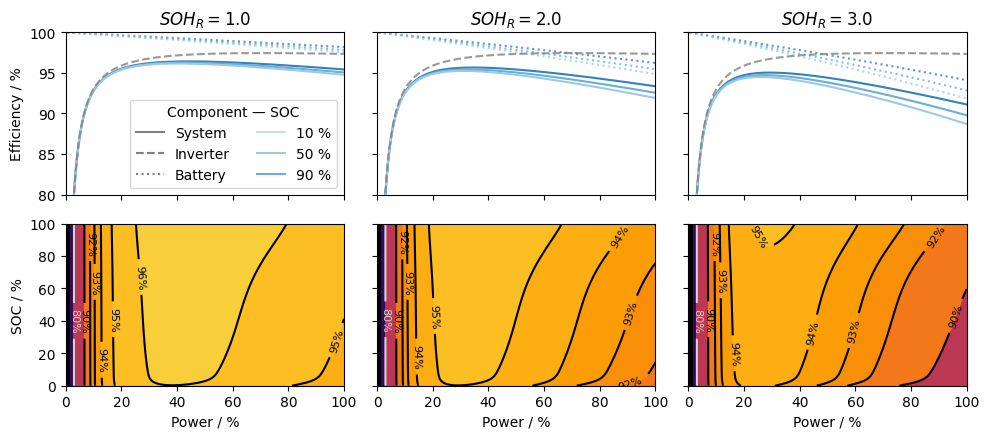

In [12]:
fig1 = plot_efficiency()

In [13]:
fig1.savefig("../figs/efficiency.pdf", bbox_inches='tight')

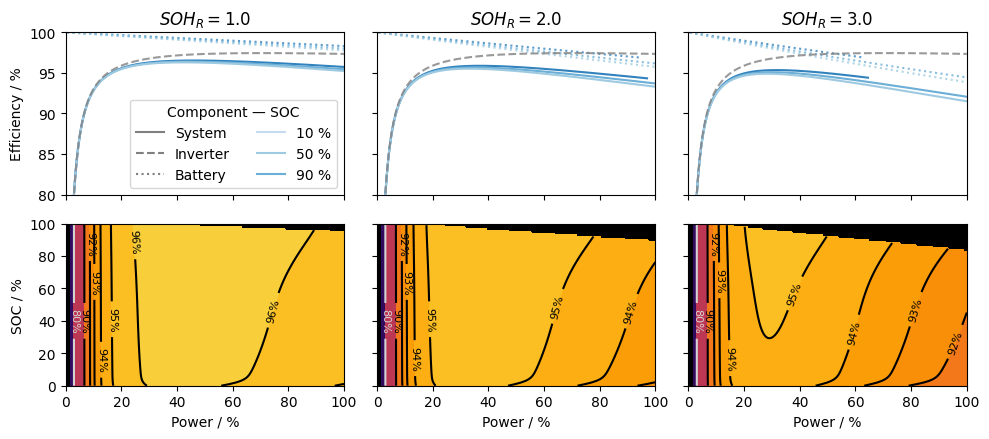

In [ ]:
fig2 = plot_efficiency(discharge=False) #charge direction

# Parameter fit: $\eta$

In [20]:
def eff_cost(power, eff):
    # build system
    batt = Battery(r=0.819e-3, circuit=(260, 2), imax=(-200, 200), vmax=(2.7, 4.15))
    acdc = ConverterConstant(max_power=180e3, eff=eff)
    sys = System(battery=batt, converter=acdc)

    # simulate
    soc = 0.5
    return np.array([sys.loss(p, soc) for p in power]) / 180e3    

# reference system
batt = Battery(r=0.819e-3, circuit=(260, 2), imax=(-200, 200), vmax=(2.7, 4.15))
converter_params = {"k0": 0.00601144, "k1": 0.00863612, "k2": 0.01195589, "m0": 100}
acdc1 = Converter(max_power=180e3, **converter_params)
sys1 = System(battery=batt, converter=acdc1)

# data
power_factor = np.linspace(0, 1, 201) 
power = power_factor * 180e3
soc = 0.5
loss1 = np.array([sys1.loss(p, soc) for p in power]) / 180e3

# fit
p0 = curve_fit(eff_cost, power, loss1)

print(f"Converter efficiency fit: {float(p0[0][0]):.1%}")

Converter efficiency fit: 97.3%


In [21]:
def eff_cost(power, eff):
    acdc = ConverterConstant(max_power=180e3, eff=eff)
    return np.array([acdc.loss(p) for p in power]) / 180e3    

print("Efficiency fit:")
# reference system
for soh_r in (1, 2, 3):
    batt = Battery(r=0.819e-3*soh_r, circuit=(260, 2), imax=(-200, 200), vmax=(2.7, 4.15))
    converter_params = {"k0": 0.00601144, "k1": 0.00863612, "k2": 0.01195589, "m0": 100}
    acdc1 = Converter(max_power=180e3, **converter_params)
    sys1 = System(battery=batt, converter=acdc1)

    # fit data
    power_factor = np.linspace(0, 1, 201) 
    power = power_factor * 180e3
    soc = 0.5
    loss1 = np.array([sys1.loss(p, soc) for p in power]) / 180e3

    p1 = curve_fit(eff_cost, power, loss1)

    print(f"SOH_R{soh_r}: {float(p1[0][0]):.1%}")

Efficiency fit:
SOH_R1: 95.9%
SOH_R2: 94.6%
SOH_R3: 93.3%


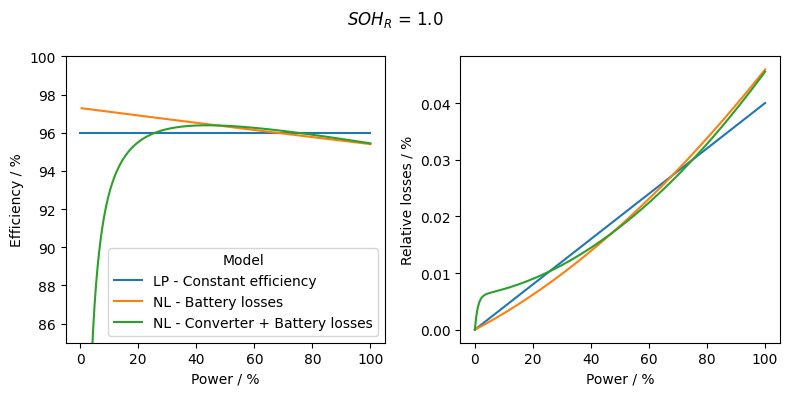

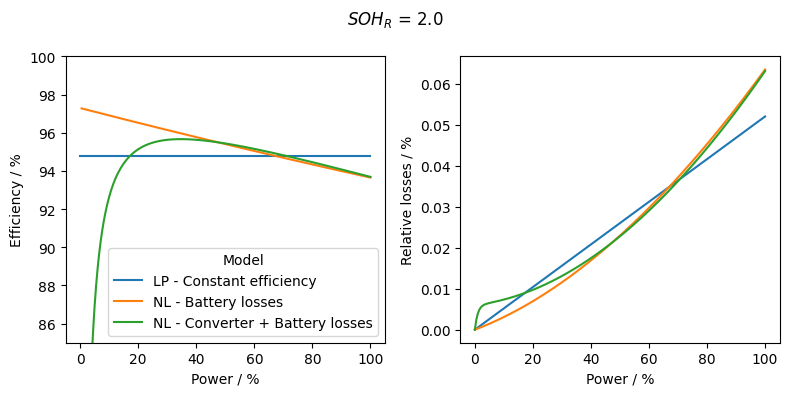

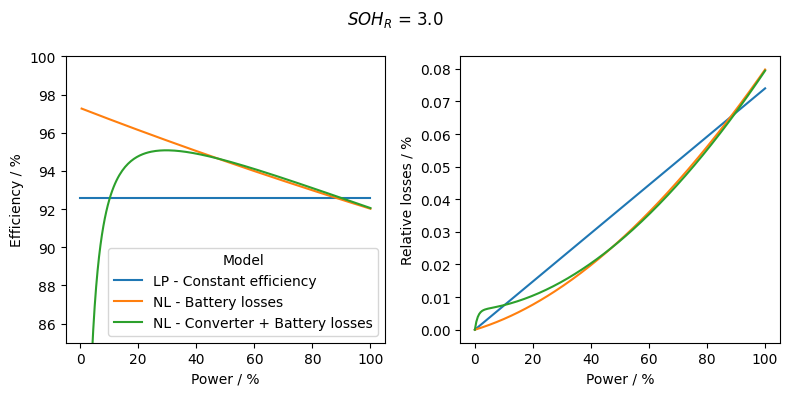

In [18]:
for soh_r, eff in zip((1, 2, 3), (0.96, 0.948, 0.926)):
    batt = Battery(r=0.819e-3*soh_r, circuit=(260, 2), imax=(-200, 200), vmax=(2.7, 4.15))

    converter_params = {"k0": 0.00601144, "k1": 0.00863612, "k2": 0.01195589, "m0": 100}
    acdc1 = Converter(max_power=180e3, **converter_params)

    acdc2 = ConverterConstant(max_power=180e3, eff=0.973)

    sys1 = System(battery=batt, converter=acdc1)
    sys2 = System(battery=batt, converter=acdc2)
    sys3 = ConverterConstant(max_power=180e3, eff=eff)

    soc = 0.5
    power_factor = np.linspace(0, 1, 201) 
    power = power_factor * 180e3

    eff1 = np.array([sys1.eff(p, soc) for p in power]) * 100
    loss1 = np.array([sys1.loss(p, soc) for p in power]) / 180e3

    eff2 = np.array([sys2.eff(p, soc) for p in power]) * 100
    loss2 = np.array([sys2.loss(p, soc) for p in power]) / 180e3

    eff3 = np.array([sys3.eff(p) for p in power]) * 100
    loss3 = np.array([sys3.loss(p) for p in power]) / 180e3

    fig3, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    ax[0].plot(power_factor * 100, eff3, label="LP - Constant efficiency")
    ax[1].plot(power_factor * 100, loss3)
    ax[0].plot(power_factor * 100, eff2, label="NL - Battery losses")
    ax[1].plot(power_factor * 100, loss2)
    ax[0].plot(power_factor * 100, eff1, label="NL - Converter + Battery losses")
    ax[1].plot(power_factor * 100, loss1)

    ax[0].set_xlabel("Power / %")
    ax[1].set_xlabel("Power / %")
    ax[0].set_ylabel("Efficiency / %")
    ax[1].set_ylabel("Relative losses / %")
    ax[0].set_ylim(85, 100)
    ax[0].legend(title="Model", loc="lower right")
    fig3.suptitle(f"$SOH_R$ = {soh_r:.1f}")
    fig3.tight_layout()